<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Alesya%20Moroz/Profpatolog_final(2)_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4%D1%8B_%D0%BD%D0%B5_%D0%BE%D0%B1%D0%BD%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D1%8B!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Цель проекта:
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы:
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.

## План проекта


1.   EDA (разведывательный анализ данных)
2.   Парсинг данных
3.   Разработка нейросети





---



# 01_Загрузка библиотек

In [ ]:
# %pip install tf-nightly

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.metrics import Recall, Precision #,F1Score
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from pandas.core.common import flatten

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import seaborn as sns
import random

# import autokeras as ak

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


# 02_Работа с нормативной документацией. Формирование справочников
Для универсальности используем токенайзер, во избежание переписывания функций при изменении входных данных (например добавлении или удалении каких-либо параметров)

## 02.1 Функции

In [ ]:
#@title функция для перевода значений/диапазонов МКБ в список

def mkb_to_sequence(arg, values_list):
    lst = []
    new = re.split(r',', arg)
    for i in range(len(new)):
            w = re.sub(r' ','', new[i]).split('-')
            lst.append(w)

    sequence_lst = []
    for i in range(len(lst)):
        value = lst[i]
        index_lst = []

        for j in value:
            index = values_list.index(j)
            index_lst.append(index)

        if len(index_lst) > 1:
            sequence = values_list[index_lst[0]:index_lst[1]+1]
            value = sequence[-1]
            index = values_list.index(value)
        else:
            sequence = value

        i = 1
        while values_list[index+i][2] == values_list[index][2]:
            sequence.append(values_list[index+i])
            i += 1

        sequence_lst.extend(sequence)

    return sequence_lst

In [ ]:
#@title функция для перевода значений/диапазонов вредных факторов в список
def hfactor_to_sequence(arg, values_list):

    factor_lst = []
    new = re.split(r',', arg) # входящую строку разделим по запятым - получим список со значениями/дипазонами
    # print('Значения: (', arg, ')')

    # проходим по списку, удаляем  nan и формируем вложенные списки со значениями или границами диапазонов
    for i in range(len(new)):
            if re.search(r'[^\W\d]', new[i]) == None:   # исключаем наличие буквенных символов во вредных факторах в т.ч 'nan'
                w = re.sub(r' ','', new[i]).split('-')  # убираем пробелы и разделяем диапазон по '-'
                factor_lst.append(w)                    # формируем вложенные списки со значениями и/или границами диапазонов вредных факторов


    # формируем общую последовательность вредных
    sequence_lst = []

    # проходим по ранее сформированному списку со значениями и/или границами диапазонов вредных факторов и формируем диапазоны индексов
    for i in range(len(factor_lst)):
        value = factor_lst[i]
        # print('value', value)

        index_lst = [] # создаем список индексов

        # если в списке одно значение:
        if len(value) == 1:
            sequence_lst.extend(value)  # значение заносится в общий список вредных факторов как есть

        # если в списке диапазон значений:
        else:
            # если в списке диапазон (1 - 5):
            if value == ['1','5']:
                index_lst = [0,192]

            else:
                for j in value:
                    try:
                        index = values_list.index(j)
                        index_lst.append(index)
                    except:
                        try:
                            j = j+'.1'
                            index = values_list.index(j)
                            index_lst.append(index)
                        except:
                            pass

            # используем диапазоны индексов для формирования последовательности вредных факторов
            if len(index_lst) > 1:
                sequence = values_list[index_lst[0]:index_lst[1]+1]
            else:
                sequence = value

            sequence_lst.extend(sequence)


    # print('Список вредных факторов: ', sequence_lst)
    # print('Длина списка:', len(sequence_lst), '\n')
    return sequence_lst

In [ ]:
#@title функция для формирования всех возможных сочетаний МКБ - Вредный фактор

def get_pairs(arg):
    pairs_lst =[]
    for i, mkb in enumerate(arg['mkb_lst']):
        for j, factor in enumerate(arg['factor_lst']):
            # print('pairs:', mkb, factor)
            pairs_lst.append((mkb, factor))
    return pairs_lst

## 02.2 Справочники

In [ ]:
#@title Справочник Пол Клиента (Справочник принятый в компании для данного поля)

gender_list = ['Женский', 'Мужской', 'Не указан']

In [ ]:
#@title Справочник 'ДиспансернаяГруппаПредставление' (Справочник принятый в компании для данного поля)

dispensary_list = ['I', 'II', 'IIIа', 'IIIб']


In [ ]:
#@title Справочник заключений профильных специалистов Годен/НеГоден

conclusion_list = ['годен', 'ограниченно годен', 'не годен', 'не определено']
print(conclusion_list )

['годен', 'ограниченно годен', 'не годен', 'не определено']


In [ ]:
#@title Справочник 'ВредныеФакторы'
# В данном ноутбуке справочник 'ВредныеФакторы' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_factors = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Вредные факторы_справочник - _из приказа 29н (ред)(2).csv')
# df_factors.info()

# print('\nПример записей в справочнике:\n')
# print(df_factors.sample(5))

# Формирование справочника(списка) цифровых кодов:

hfactor_list = df_factors['Вредный фактор_код'].to_list()
print('\nПредставление справочника Вредные Факторы: ',hfactor_list[:10], '\n')
print('Длина справочника Вредные Факторы: ',len(hfactor_list))


Представление справочника Вредные Факторы:  ['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2'] 

Длина справочника Вредные Факторы:  226


In [ ]:
#@title Справочник 'МКБ'
# В данном ноутбуке справочник 'МКБ' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_mkb_catalog = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/spr_mkb10.xls')
# df_mkb_catalog.info()

print('---')
print('\nПример записей в нормативном документе:')
print(df_mkb_catalog[:5],'\n')

# Из справочника нам необходимы цифровые коды столбец 'mkb_cod'

mkb_list = df_mkb_catalog['mkb_cod'].to_list()
print('Представление справочника МКБ: ', mkb_list[:10], '\n')
print('Длина справочника МКБ: ', len(mkb_list))

---

Пример записей в нормативном документе:
  mkb_cod                                           mkb_name  class_id
0     A00                                             Холера       101
1   A00.0  Холера, вызванная холерным вибрионом 01, биова...       101
2   A00.1  Холера, вызванная холерным вибрионом 01, биова...       101
3   A00.9                                Холера неуточненная       101
4     A01                                      Тиф и паратиф       101 

Представление справочника МКБ:  ['A00', 'A00.0', 'A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4'] 

Длина справочника МКБ:  12941


In [ ]:
#@title Объединенный справочник для векторизации

vocabulary = gender_list + dispensary_list + hfactor_list + mkb_list #  + conclusion_list

print(vocabulary[:13])
print(vocabulary[235:245])
print('\nДлина общего справочника: ',len(vocabulary))

['Женский', 'Мужской', 'Не указан', 'I', 'II', 'IIIа', 'IIIб', '1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1']
['A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4', 'A02', 'A02.0']

Длина общего справочника:  13174


## 02.3 Загрузка и редактирование нормативной документации (приложение №2 Приказа 29н )

В данном разделе будет отредактировано приложение №2 Приказа 29н от от 28 января 2021 г. Все диапазоны Вредных факторов и кодов МКБ будут переведены в формат списков, в соответствии со справочниками.

In [ ]:
# загрузка отредатированного приложения №2 Приказа 29н

df_29n = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Противопоказания - из приказа 29н (ред) 2.csv')
df_29n.sample(5)

,"N пп в Приложении 2, приказ 29н",Класс заболевания,"Наименование болезней, степень нарушения функции организма",Код по МКБ-10,Вредные и (или) опасные производственные факторы,Виды работ,Профпригодность,Примечания
87,46.а,Класс XII. Болезни кожи и подкожной клетчатки,Хронические болезни кожи и подкожной клетчатки...,L00 - L98,1 - 5,6 - 27,не годен,а) тяжелые формы заболеваний
11,8.г,Класс II. Новообразования,Доброкачественные новообразования: г) новообра...,"D10, D14.1",5.2.2,NaN,врачебная комиссия,Решение вопроса о профессиональной пригодности...
22,14.б,Класс VI. Болезни нервной системы,Воспалительные заболевания центральной нервной...,G00 - G09,1.52.6,NaN,не годен,Легкие формы заболеваний с рецидивирующим тече...
54,34.а,Класс IX. Болезни системы кровообращения,"Хронические воспалительные болезни сердца, бол...","I05 - I09, I30 - I42",1 - 5,6 - 22,не годен,После лечения решение вопроса о профессиональн...
10,8.в,Класс II. Новообразования,Доброкачественные новообразования: в) новообра...,D14.0,NaN,11 - 13,врачебная комиссия,Решение вопроса о профессиональной пригодности...


In [ ]:
# объединяем столбцы 'Вредные и (или) опасные производственные факторы ' и  'Виды работ' в один столбец

columns = ['Вредные и (или) опасные производственные факторы ',
           'Виды работ']

df_29n['Производственные факторы'] = df_29n[columns].astype(str).agg(','. join , axis= 1)

In [ ]:
# перевод диапазонов Вредных факторов и кодов МКБ в формат списков, в соответствии со справочниками.

df_29n['mkb_lst'] = df_29n['Код по МКБ-10'].apply(lambda x: mkb_to_sequence(x, mkb_list))
df_29n['factor_lst'] = df_29n['Производственные факторы'].apply(lambda x: hfactor_to_sequence(x, hfactor_list))
df_29n['pairs_lst'] = df_29n.apply(get_pairs, axis = 1)

In [ ]:
# выводим развернутые значения диапазонов и пары (mmb - hfactor) на экран

df_29n[['mkb_lst', 'factor_lst', 'pairs_lst']].sample(3)

,mkb_lst,factor_lst,pairs_lst
8,"[D10, D10.0, D10.1, D10.2, D10.3, D10.4, D10.5...","[1.6, 1.7.2, 1.10, 1.11, 1.12, 1.22, 1.27, 1.3...","[(D10, 1.6), (D10, 1.7.2), (D10, 1.10), (D10, ..."
89,"[L23, L23.0, L23.1, L23.2, L23.3, L23.4, L23.5...","[1.1, 1.2, 1.4, 1.5.1, 1.6, 1.7, 1.7.1, 1.7.2,...","[(L23, 1.1), (L23, 1.2), (L23, 1.4), (L23, 1.5..."
56,"[I10, I10.9, I11, I11.0, I11.9, I12, I12.0, I1...","[1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...","[(I10, 1.1), (I10, 1.2), (I10, 1.3), (I10, 1.4..."


In [ ]:
# df_29n.info()

# 03_Работа с датасетом заказчика
В данном разделе проводится анализ и редактирование датасета, предоставленного заказчиком. В рамках данного этапа будут выполнены следующие задачи: поиск пустых строк и пустых столбцов, анализ данных по направлениям исследований, удаление столбцов с ненужной информацией (для поставленной задачи), формирование новых столбцов.

## 03.1 Загрузка датасета

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Весь период(1).csv', sep=';')

In [ ]:
df.sample(5) # выводим на экран 5 случайных записей из датасета

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
23536,308764af-953b-11ec-80fe-0cc47aab8067,5b8e8db1-92d5-11ec-80fe-0cc47aab8067,1977-08-31T00:00:00,Мужской,Мужской,2022-02-24T00:00:00,Периодический,Периодический,False,694a9464-7fae-11ea-80dd-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11491,060118d4-0bef-11ed-8103-0cc47aab8067,a208761b-07ff-11ed-8103-0cc47aab8067,1962-10-10T00:00:00,Мужской,Мужской,2022-07-25T00:00:00,Периодический,Периодический,True,0b15bc61-618c-11ec-80fc-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5202,f52c72ce-9b70-11ec-80fe-0cc47aab8067,11f507c2-d901-11e7-80de-708bcd7f83cd,1969-05-15T00:00:00,Мужской,Мужской,2022-03-04T00:00:00,Периодический,Периодический,False,11f507bd-d901-11e7-80de-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32188,bc21aea8-04ec-11ee-8131-0cc47aab8067,8b2ede6a-e0e8-11ec-8101-0cc47aab8067,1982-12-25T00:00:00,Мужской,Мужской,2023-06-07T00:00:00,Периодический,Периодический,False,c81108a6-c6d5-11ec-8100-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18635,addfe0a5-6fa2-11ed-8109-0cc47aab8067,34a045bd-6f05-11ed-8109-0cc47aab8067,1990-04-06T00:00:00,Женский,Женский,2022-11-29T00:00:00,Периодический,Периодический,False,04d5e72c-6efc-11ed-8109-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Columns: 289 entries, ДокументПрохождениеМедосмотра to Эндоскопия1_МКБ102
dtypes: bool(1), float64(75), object(213)
memory usage: 71.9+ MB


In [ ]:
#@title Размерность исходного датасета
print('Количество строк:   ', df.shape[0])
print('Количество столбцов:', df.shape[1])

Количество строк:    32686
Количество столбцов: 289


In [ ]:
# просмотр наименований первых 20 столбцов
df.columns[:20]

Index(['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения',
       'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра',
       'ТипМедосмотра', 'ТипМедосмотраПредставление',
       'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия',
       'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение',
       'ВредныеФакторы',
       'Гинекология1_Диагноз_ЗначениеПредставлениеПредставление',
       'Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103'],
      dtype='object')

## 03.2 Редактирование датасета

In [ ]:
#@title Проверка наличия пропусков по столбцу 'Клиент'
if df['Клиент'].isna().sum() > 0:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())
    df = df.dropna(subset=['Клиент'])
    print('Удалены строки с пустыми значениями в столбце "Клиент"')
else:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())

Количество строк с пропусками: 0


In [ ]:
#@title Проверка наличия пропусков по столбцу 'ВредныеФакторы'
if df['ВредныеФакторы'].isna().sum() > 0:
    print('Количество строк с пропусками:', df['ВредныеФакторы'].isna().sum())
    df = df.dropna(subset=['ВредныеФакторы'])
    print('Удалены строки с пустыми значениями в столбце "ВредныеФакторы"')
else:
    print('Количество строк с пропусками:', df['ВредныеФакторы'].isna().sum())

Количество строк с пропусками: 960
Удалены строки с пустыми значениями в столбце "ВредныеФакторы"


### Корректировка данных по целевому столбцу 'ЗаключениеМК'
1. Удаление строк со значениями "nan"
2. Удаление строк с нерелевантной информацией (при наличии)

In [ ]:
print('Количество строк с пропусками в столбце "ЗаключениеМК":             ', df['ЗаключениеМК'].isna().sum())
print('Количество строк с пропусками в столбце "ЗаключениеМКПредставление":', df['ЗаключениеМКПредставление'].isna().sum())
print('Количество строк с пропусками в столбце "Заключение":               ', df['Заключение'].isna().sum())
# df[pd.isna(df['ЗаключениеМК'])]['ЗаключениеМК']

Количество строк с пропусками в столбце "ЗаключениеМК":              13236
Количество строк с пропусками в столбце "ЗаключениеМКПредставление": 13236
Количество строк с пропусками в столбце "Заключение":                13687


In [ ]:
# проверяем релевантность значений в столбце "ЗаключениеМК"

print(df['ЗаключениеМК'].value_counts())

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Газоспасатель                           2
 п. 11.3                                1
машинист бульдозера                     1
 Газоспасатель                          1
Name: ЗаключениеМК, dtype: int64


видим нерелевантные значения в столбце 'ЗаключениеМК': 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'

In [ ]:
# функция для удаления строки со значением nan и нерелевантными значениями

def clean_column(dataframe, name_series, irrelevant_values):
    df_cleaned = dataframe.dropna(subset=[name_series])

    for i in irrelevant_values:
        df_cleaned = df_cleaned.loc[df[name_series] != i]

    return df_cleaned

In [ ]:
irrelevant_values = ['машинист бульдозера', 'Газоспасатель', ' Газоспасатель',  ' п. 11.3']
name_series = 'ЗаключениеМК'
df_01 = clean_column(df,name_series, irrelevant_values)

In [ ]:
print(df_01['ЗаключениеМК'].value_counts())

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Name: ЗаключениеМК, dtype: int64


In [ ]:
# df_01['ЗаключениеМК'].isna().sum()

### Удаление столбцов

In [ ]:
#@title  с дублирующей информацией
# столбцы 'ЗаключениеМКПредставление', 'Заключение' удаляем из датасета, как дублирующие

df_01 = df_01.drop(['ЗаключениеМКПредставление', 'Заключение'], axis='columns')

In [ ]:
#@title  с нулевыми значениями

df_02 = df_01.dropna(axis='columns',how='all')

In [ ]:
print('df_01: ', df_01.shape)
print('df_02: ', df_02.shape)
print('удалено пустых столбцов:', df_01.shape[1] - df_02.shape[1] )

df_01:  (18485, 287)
df_02:  (18485, 203)
удалено пустых столбцов: 84


In [ ]:
#@title  с нерелевантной информацией

keywords_to_drop = 'ДатаПриема|_Дата|Документ|Салон|Специализация|Врач|ПсихОсвидетельствование|Контрагент'
columns_to_drop = list(df_02.filter(regex=keywords_to_drop).columns)
df_03 = df_02.drop(columns_to_drop, axis='columns')

# print('df_02: ', df_02.shape)
# print('df_03: ', df_03.shape)
print('столбцов к удалению:',len(columns_to_drop))
print('удалено столбцов:   ', df_02.shape[1] - df_03.shape[1] )

столбцов к удалению: 3
удалено столбцов:    3


### Фильтрация столбцов для финального датасета

В данной части будут отфильтрованы столбцы для дальнейшего использования в части формирования обучающих и тестовых данных. В датасет будут включены столбцы отвечающие следующим требованиям:
1. Столбцы с общей информацией
2. Столбцы с признаком "Представление"
3. Столбцы с признаком

In [ ]:
#@title  Столбцы с общей информацией

columns_general = ['КлиентДатаРождения',
                   'КлиентПолПредставление',
                   'ДатаЗавершенияМедосмотра',
                   'Профессия',
                   'ВредныеФакторы',
                   'ЗаключениеМК']

print('Количество столбцов с общей информацией:', len(columns_general ))

Количество столбцов с общей информацией: 6


In [ ]:
#@title  Столбцы с признаком "Представление" + "Профнепригодность"
# столбцы с признаком "Представление" содержат дублирующую или обобщенную информацию со столбцами аналогичного наименования
# столбцы с признаком "Профнепригодность" содержат информацию годен/негоден по профильным специалистам

# keywords_unsuitability = 'Профнепригодность'
# df_04 = df_03.filter(regex=keywords_unsuitability)

# keywords_representation = 'Представление'
# columns_representation = list(df_03.filter(regex=keywords_representation).columns)[3:]

# print('Количество столбцов с признаком "Представление":', len(columns_representation))
# print()
# columns_representation[:5]

In [ ]:
#@title  Столбцы с признаком "МКБ"
# Столбцы с признаком "МКБ" содержат основную информацию о поставленных диагнозах в разрезе профильных специалистов

keywords_mkb = 'МКБ'
columns_mkb = list(df_03.filter(regex=keywords_mkb).columns)

print('Количество столбцов с признаком "МКБ":', len(columns_mkb))
print()
columns_mkb[:5]

Количество столбцов с признаком "МКБ": 189



['Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология1_МКБ103',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102']

In [ ]:
# Объединение отфильтрованных столбцов

columns_final = columns_general + columns_mkb  #  + columns_representation
print('Количество столбцов для финального датасета:', len(columns_final))

Количество столбцов для финального датасета: 195


In [ ]:
df_final = df_03[columns_final]
df_final.reset_index(drop= True , inplace= True) # сбрасываем индексацию строк
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Columns: 195 entries, КлиентДатаРождения to Эндоскопия1_МКБ102
dtypes: object(195)
memory usage: 27.5+ MB


In [ ]:
df_final['ЗаключениеМК'].value_counts()

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Name: ЗаключениеМК, dtype: int64



> Выше видна серьезня разбалансировка датасета: всего 3 позиции(строки) с признаком "Негоден" против примерно 1200 записей с признаком "ОграниченноГоден" и порядка 17000 - "Годен"



> Для балансировки классов добавим позиции "Негоден" из нормативной документации (приложение №2 Приказа 29н), а позиции "Годен" сократим случайным выбором строк




###  Форматирование столбца Вредные факторы (есть включения с датами)

In [ ]:
#@title определение множества уникальных значений дат в столбце ВредныеФакторы'
# для последующей корректировки

factor_exeption = []

for i, values in enumerate(df_final['ВредныеФакторы']):
    splitted = re.split(r',', str(values))
    # print('splitted',splitted)

    for j, value in enumerate(splitted):
        if hfactor_list.count(value) == 0:
            # print('---', value)
            factor_exeption.append(value)

set_hfactor = set(factor_exeption)
print(set_hfactor)
print('\nКоличество уникальных значений для корректировки:', len(list(set_hfactor)))

{'янв.50', '04.окт', '04.02.2003', 'янв.49', 'янв.23', '04.апр', '04.авг', '06.янв', '04.сен', '04.янв', '18.фев', '05.фев', '06.фев', '04.02.2005', '02.04.2003', '03.фев', 'янв.48', '04.03.2002', '04.02.2001', '01.фев', '11.апр', 'янв.25', '05.янв', '18.янв', '11.янв', '04.03.2001', '01.май', '02.04.2001', '11.мар', '04.июл', '04.02.2004', 'янв.46'}

Количество уникальных значений для корректировки: 32


In [ ]:
# создаем словарь для корректировки данных

correct_dict = {'04.03.2002' : '4.3.2',
                '04.авг' : '4.8',
                '11.мар' : '11.3',
                '18.фев' : '18.2',
                '06.фев' : '6.2',
                'янв.46' : '1.46',
                '04.июл' : '4.7',
                '02.04.2001' : '2.4.1',
                '05.фев' : '5.2',
                '11.апр' : '11.4',
                '04.03.2001' : '4.3.1',
                '04.02.2005' : '4.2.5',
                '11.янв' : '11.1',
                '03.фев' : '3.2',
                '05.янв' : '5.1',
                'янв.23' : '1.23',
                '18.янв' : '18.1',
                '04.янв' : '4.1',
                'янв.48' : '1.48',
                '04.02.2004' : '4.2.4',
                'янв.49' : '1.49',
                'янв.50' : '1.50',
                '02.04.2003' : '2.4.3',
                '04.сен' : '4.9',
                '04.02.2003' : '4.2.3',
                '01.май' : '1.5',
                '04.окт' : '1.10',
                '04.02.2001' : '4.2.1',
                '04.апр' : '4.4',
                'янв.25' : '1.25',
                '01.фев' : '1.2',
                '06.янв' : '6.1'}

print('Длина словаря для корректировки:' ,len(correct_dict))

Длина словаря для корректировки: 32


In [ ]:
def hfactor_corr(arg):
    hfactor = arg
    arg_key = correct_dict.get(arg)
    if arg_key != None:
        hfactor = arg_key
    return hfactor

In [ ]:
df_final['ВредныеФакторы_2'] = df_final['ВредныеФакторы'].apply(hfactor_corr)

In [ ]:
# проверим отсутствие нерелевантных значений в столбце со значениями вредных факторов
factor_exeption = []
for i, values in enumerate(df_final['ВредныеФакторы_2']):
    splitted = re.split(r',', str(values))
    # print('splitted',splitted)

    for j, value in enumerate(splitted):
        if hfactor_list.count(value) == 0:
            # print('---', value)
            factor_exeption.append(value)

print()
print(factor_exeption)


[]


# 04_Tokenizer

In [ ]:
#@title Определение токенайзера

max_tokens = len(vocabulary)+1
tokenizer = Tokenizer(num_words=max_tokens,
                             filters='!"#$%&()*+-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                             lower=False,
                             split=',',
                             oov_token='unknown',
                             char_level=False)


tokenizer.fit_on_texts(vocabulary)

In [ ]:
print(tokenizer.word_index)

{'unknown': 1, 'Женский': 2, 'Мужской': 3, 'Не указан': 4, 'I': 5, 'II': 6, 'IIIа': 7, 'IIIб': 8, '1.1': 9, '1.2': 10, '1.3': 11, '1.4': 12, '1.5': 13, '1.5.1': 14, '1.6': 15, '1.7': 16, '1.7.1': 17, '1.7.2': 18, '1.8': 19, '1.8.1': 20, '1.8.1.1': 21, '1.8.1.2': 22, '1.8.2': 23, '1.8.2.1': 24, '1.8.2.2': 25, '1.8.3': 26, '1.8.3.1': 27, '1.8.3.2': 28, '1.8.4': 29, '1.8.4.1': 30, '1.8.4.2': 31, '1.9': 32, '1.10': 33, '1.11': 34, '1.12': 35, '1.13': 36, '1.14': 37, '1.14.1': 38, '1.14.2': 39, '1.15': 40, '1.15.1': 41, '1.16': 42, '1.17': 43, '1.18': 44, '1.18.1': 45, '1.18.2': 46, '1.18.3': 47, '1.19': 48, '1.19.1': 49, '1.19.2': 50, '1.19.3': 51, '1.20': 52, '1.21': 53, '1.22': 54, '1.23': 55, '1.24': 56, '1.25': 57, '1.26': 58, '1.27': 59, '1.27.1': 60, '1.27.2': 61, '1.28': 62, '1.29': 63, '1.29.1': 64, '1.29.2': 65, '1.29.3': 66, '1.29.4': 67, '1.29.5': 68, '1.30': 69, '1.30.1': 70, '1.31': 71, '1.32': 72, '1.33': 73, '1.34': 74, '1.34.1': 75, '1.34.2': 76, '1.35': 77, '1.36': 78, '1.

In [ ]:
#@title Функция для токенизации элементов датафрейма

def tokenization_x(arg):
    # for i in arg:
    #     print(i)
    k = tokenizer.texts_to_sequences(arg)
    n = tokenizer.sequences_to_matrix(k)
    f = sum(n)
    return f

# 05_Формирование датафрейма для работы

Поля в датафрейме

| имя столбца | определение |
|----------|----------|
|gender|пол пациента|
|hfactors|Вредные факторы|
|mkb|диагноз в формате кодов МКБ|
|conclusion|Заключение|



In [ ]:
#@title Функция для очистки данных

def cleandata(arg):
    splitted = re.split(r',', arg)

    unique = []
    for i in splitted:
        if i not in unique:
            unique.append(i)
    unique.remove('nan') # убираем из значений nan

    if unique:
        return unique
    else:
        return np.NaN

In [ ]:
df_work = pd.DataFrame() # создаем пустой датафрейм

In [ ]:
df_work['gender'] = df_final['КлиентПолПредставление']

In [ ]:
df_work['hfactors'] = df_final['ВредныеФакторы_2'].apply(lambda x: re.split(r',', x))
df_work.head(7)

,gender,hfactors
0,Женский,[1.10]
1,Женский,[23]
2,Женский,[23]
3,Женский,[23]
4,Женский,[23]
5,Женский,[25]
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]"


In [ ]:
df_work['mkb'] = df_final[columns_mkb].astype(str).agg(','. join , axis= 1).apply(cleandata)
df_work.head(7)

,gender,hfactors,mkb
0,Женский,[1.10],[Z00.0]
1,Женский,[23],[Z00.0]
2,Женский,[23],[Z00.0]
3,Женский,[23],[Z00.0]
4,Женский,[23],[Z00.0]
5,Женский,[25],[Z00.0]
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]","[Z00.0, K29.9]"


In [ ]:
df_work['conclusion'] = df_final['ЗаключениеМК']
df_work.head(7)

,gender,hfactors,mkb,conclusion
0,Женский,[1.10],[Z00.0],Годен
1,Женский,[23],[Z00.0],Годен
2,Женский,[23],[Z00.0],Годен
3,Женский,[23],[Z00.0],Годен
4,Женский,[23],[Z00.0],Годен
5,Женский,[25],[Z00.0],Годен
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]","[Z00.0, K29.9]",Годен


In [ ]:
df_work[:1]

,gender,hfactors,mkb,conclusion
0,Женский,[1.10],[Z00.0],Годен


In [ ]:
#@title Проверка наличия пропусков по столбцу 'mkb'

if df_work['mkb'].isna().sum() > 0:
    print('Количество строк с пропусками:', df_work['mkb'].isna().sum())
    df_work = df_work.dropna(subset=['mkb'])
    print('Удалены строки с пустыми значениями в столбце "mkb"')
else:
    print('Количество строк с пропусками:', df_work['mkb'].isna().sum())

Количество строк с пропусками: 3381
Удалены строки с пустыми значениями в столбце "mkb"


In [ ]:
df_work['conclusion'].value_counts()

Годен                               13896
ГоденСКоррекциейЗрения               1107
ГоденБезРаботНаВысотах                 51
НуждаетсяВДообследованииИЛечении       39
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        3
Негоден                                 3
Name: conclusion, dtype: int64

In [ ]:
#@title Выбор случайных строк с параметром "Годен" в количестве 1200

df_fit = df_work[df_work['conclusion'] == 'Годен'].sample(1500)
df_lim_fit = df_work[df_work['conclusion'] != 'Годен']

In [ ]:
print('Годен', df_fit['conclusion'].value_counts().sum())
print('Ограничено годен', (df_lim_fit['conclusion'].value_counts().sum())-(3+39)) # исключаем позиции Негоден и НуждаетсяВДообследованииИЛечении

Годен 1500
Ограничено годен 1166


In [ ]:
df_work_2 = pd.concat([df_fit, df_lim_fit])
df_work_2.reset_index()
df_work_2['conclusion'].value_counts()

Годен                               1500
ГоденСКоррекциейЗрения              1107
ГоденБезРаботНаВысотах                51
НуждаетсяВДообследованииИЛечении      39
ГоденСКоррекциейСлуха                  5
ОграниченноГоден                       3
Негоден                                3
Name: conclusion, dtype: int64

In [ ]:
df_work_2.reset_index(drop= True, inplace= True)
df_work_2

,gender,hfactors,mkb,conclusion
0,Мужской,"[4.2.5, 11.1, 11.4]",[Z00.0],Годен
1,Мужской,"[4.2.5, 6.1, 9]",[Z00.0],Годен
2,Женский,"[18.1, 23]",[Z00.0],Годен
3,Мужской,"[1.1, 1.23, 1.39, 3.1.7, 4.2.1, 5.1, 9]","[Z00.0, I11.9]",Годен
4,Мужской,"[1.50, 3.1.8.2, 4.3.2, 4.4, 11.1, 18.1, 18.2]",[Z00.0],Годен
...,...,...,...,...
2703,Мужской,"[1.50, 4.2.5, 6, 6.1, 6.2, 9]","[Z00.0, I67.4, H52.0, I11.9]",ГоденБезРаботНаВысотах
2704,Мужской,"[4.2.5, 6, 11.1]","[Z00.0, H52.0]",ГоденСКоррекциейЗрения
2705,Женский,"[6.1, 6.2, 4.4, 9]","[Z00.0, H52.1]",ГоденСКоррекциейЗрения
2706,Женский,[5.1],"[Z00.0, H52.1]",ГоденСКоррекциейЗрения


## Добавление позиций с признаком "Негоден" из нормативной документации (приложение №2 Приказа 29н ) методом случайного выбора


In [ ]:
df_work_3 = df_work_2.copy()

In [ ]:
i = 0
while i < 1200:
    # lst = []
    conclusion = 'Негоден'

    random_29n_idx = random.randint(0, len(df_29n)-1)  # случайная строка из приказа 29н
    random_mkb_idx = random.randint(0, (len(df_29n['mkb_lst'][random_29n_idx])-1))  # случайное значение МКБ из приказа
    random_factor_idx= random.randint(0, (len(df_29n['factor_lst'][random_29n_idx])-1))  # случайное значение вредного фактора из приказа

    mkb = [df_29n['mkb_lst'][random_29n_idx][random_mkb_idx]]
    hfactors = [df_29n['factor_lst'][random_29n_idx][random_factor_idx]]


    gender_idx = random.randint(0, 2)
    gender = gender_list[gender_idx]

    list_to_append = [gender, hfactors, mkb, conclusion]

    df_work_3.loc[len(df_work_3.index)] = list_to_append

    # print(i, list_to_append )

    i += 1

else:
    print('Цикл окончен, добавлено', i, 'позиций "Негоден"')

Цикл окончен, добавлено 1200 позиций "Негоден"


In [ ]:
df_work_3['conclusion'].value_counts()

Годен                               1500
Негоден                             1203
ГоденСКоррекциейЗрения              1107
ГоденБезРаботНаВысотах                51
НуждаетсяВДообследованииИЛечении      39
ГоденСКоррекциейСлуха                  5
ОграниченноГоден                       3
Name: conclusion, dtype: int64

In [ ]:
df_work_3.tail(5)

,gender,hfactors,mkb,conclusion
3903,Женский,[8],[H52.1],Негоден
3904,Мужской,[21],[E66.0],Негоден
3905,Женский,[1.47.16],[H10.0],Негоден
3906,Женский,[21],[C43],Негоден
3907,Женский,[19.2],[H47.3],Негоден


In [ ]:
df_work_3.sample(10)

,gender,hfactors,mkb,conclusion
93,Женский,[25],[Z00.0],Годен
1549,Мужской,"[1.1, 4.4, 12]","[Z00.0, H52.1]",ГоденСКоррекциейЗрения
21,Мужской,"[1.30.1, 1.50, 4.4, 6.1, 6.2, 1.30.1, 1.50, 4....",[Z00.0],Годен
2842,Не указан,[23],[A54.6],Негоден
1961,Мужской,"[4.2.5, 5.1, 5.2.1, 6.2, 4.2.5, 5.1, 5.2.1, 6.2]","[Z00.0, H52.1]",ГоденСКоррекциейЗрения
315,Мужской,"[3.1.7, 4.2, 4.7, 4.8, 5.1, 6, 17, 3.1.7, 4.2,...",[Z00.0],Годен
2553,Мужской,"[1.50, 4.3.2, 4.4, 18.1, 18.2]","[Z00.0, H52.2]",ГоденСКоррекциейЗрения
2927,Женский,[21],[G04.1],Негоден
1952,Женский,[23],"[Z00.0, H90.3]",ГоденСКоррекциейСлуха
81,Мужской,"[4.2.5, 11.4]",[Z00.0],Годен


# 06_Формирование выборок

## 06.1 xTrain

### xTrain_01 (Input #1)

Для работы используем сгенерированный датафрейм

In [ ]:
df_work_3[:2]
columns_xtrain = df_work_3.columns[:3]
columns_xtrain

Index(['gender', 'hfactors', 'mkb'], dtype='object')

In [ ]:
df_work_3['hfactors'][0][0]

'4.2.5'

In [ ]:
def agg_data(arg):
    print(arg)

In [ ]:
agg_data(df_work_3['hfactors'])

0                                 [4.2.5, 11.1, 11.4]
1                                     [4.2.5, 6.1, 9]
2                                          [18.1, 23]
3             [1.1, 1.23, 1.39, 3.1.7, 4.2.1, 5.1, 9]
4       [1.50, 3.1.8.2, 4.3.2, 4.4, 11.1, 18.1, 18.2]
                            ...                      
3903                                              [8]
3904                                             [21]
3905                                        [1.47.16]
3906                                             [21]
3907                                           [19.2]
Name: hfactors, Length: 3908, dtype: object


In [ ]:
# для xTrain_01 (Input #1) объединяем столбцы с общей информацией и столбцы с признаком "МКБ"

#  columns_xtrain = ['КлиентПолПредставление', 'ВредныеФакторы_2'] + columns_mkb
df_work_3['x_raw'] = df_work_3[columns_xtrain].astype(str).agg(','. join , axis= 1 ) # объединяем данные

In [ ]:
df_work_3['x_raw'][0]

"Мужской,['4.2.5', '11.1', '11.4'],['Z00.0']"

In [ ]:
# def get_pairs(arg):
#     pairs_lst =[]
#     for i, mkb in enumerate(arg['mkb_lst']):
#         for j, factor in enumerate(arg['factor_lst']):
#             # print('pairs:', mkb, factor)
#             pairs_lst.append((mkb, factor))
#     return pairs_lst

In [ ]:
# def x_train_cleandata(arg):
#     splitted = re.split(r',', arg)
#     print(splitted)
#     s1 = splitted.map.replace("]|[", "")
#     unique = []
#     for i in s1:
#         if i not in unique:
#             unique.append(i)
#     # unique.remove('nan') # убираем из значений nan
#     print(unique)
#     return unique

In [ ]:
def x_train(arg):
    x_train_lst = []
    # x_train_lst.append(arg['gender'])
    # for p, gender in enumerate(arg['gender']):
    x_train_lst.append(arg['gender'])
    for i, factor in enumerate(arg['hfactors']):
        x_train_lst.append(factor)

    for j, mkb in enumerate(arg['mkb']):
        x_train_lst.append(mkb)

    return x_train_lst

In [ ]:
# очищаем данные
df_work_3['x_clean'] = df_work_3.apply(x_train, axis = 1)

print('Пример очищенных данных:\n')
print(df_work_3['x_clean'].sample(10))

Пример очищенных данных:

3206                               [Мужской, 1.30, A18.8]
2147    [Мужской, 4.4, 5.1, 15, Z00.0, H52.2, I11.9, I...
831                       [Мужской, 4.2.5, 6.1, 9, Z00.0]
809                                [Женский, 1.10, Z00.0]
1502                  [Мужской, 1.50, 11.3, Z00.0, H52.1]
1847                   [Мужской, 4.4, 18.1, Z00.0, H52.2]
2687                         [Мужской, 6.2, Z00.0, H52.2]
2539    [Мужской, 4.2.3, 4.7, 5.1, 6.2, 9, 11.1, 12, 1...
3704                                  [Мужской, 8, H44.2]
2589                  [Мужской, 4.9, Z00.0, H52.1, I11.9]
Name: x_clean, dtype: object


In [ ]:
df_work_3['x_clean'][4]

['Мужской', '1.50', '3.1.8.2', '4.3.2', '4.4', '11.1', '18.1', '18.2', 'Z00.0']

In [ ]:
# # очищаем данные
# df_modified['x_clean'] = df_modified['x_raw'].apply(x_train_cleandata)

# print('Пример очищенных данных:\n')
# print(df_modified['x_clean'][:15])


In [ ]:
x_train_01 = df_work_3['x_clean'].map(tokenization_x) # токенизируем очищенные данные
x_train_01 = x_train_01.apply(lambda x: pd.Series(flatten(x)))
x_train_01 = x_train_01.to_numpy() # переводим в требуемый формат - массив numpy

print(type(x_train_01))
print(x_train_01)
print(x_train_01.shape)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(3908, 13175)


In [ ]:
print(x_train_01[1][:100])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### xTrain_02 (Input #2) - данный вход будет добавлен в нейросеть если не будет достигнута требуемая точность

In [ ]:
# для xTrain_02 (Input #2) берем столбцы с заключениями в разрезе профильных специалистов (Годен - не годен)

x_train_02 = df_modified['spec_conclusions'].map(tokenization_x) # токенизируем очищенные данные
x_train_02 = x_train_02.apply(lambda x: pd.Series(flatten(x)))
x_train_02 = x_train_02.to_numpy() # переводим в требуемый формат - массив numpy

print(type(x_train_02))
print(x_train_02)
print(x_train_02.shape)

NameError: ignored

## 05_2 yTrain

In [ ]:
# анализируем данные, находящиеся в целевом столбце

df_work_3['conclusion'].value_counts()

# данные необходимо привести к единому виду : 3 целевые категории, формат OHE

Годен                               1500
Негоден                             1203
ГоденСКоррекциейЗрения              1107
ГоденБезРаботНаВысотах                51
НуждаетсяВДообследованииИЛечении      39
ГоденСКоррекциейСлуха                  5
ОграниченноГоден                       3
Name: conclusion, dtype: int64

In [ ]:
categories = ['годен', 'ограниченно годен', 'не годен']

In [ ]:
#@title Функция для приведения y_train к требуемому виду

def y_train(arg):

    limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден', 'ГоденСКоррекциейСлуха']
    categories = ['годен', 'ограниченно годен', 'не годен']

    if arg == 'Годен':
        y = 0
    elif arg in limited_eff:
        y = 1
    else:
        y = 2

    return utils.to_categorical(y, num_classes=3)

In [ ]:
df_work_3['y_train'] = df_work_3['conclusion'].apply(y_train)

print(df_work_3['y_train'].sample(10))

1439    [1.0, 0.0, 0.0]
530     [1.0, 0.0, 0.0]
3241    [0.0, 0.0, 1.0]
2121    [0.0, 1.0, 0.0]
1965    [0.0, 1.0, 0.0]
1630    [0.0, 1.0, 0.0]
3172    [0.0, 0.0, 1.0]
2952    [0.0, 0.0, 1.0]
2221    [0.0, 1.0, 0.0]
1433    [1.0, 0.0, 0.0]
Name: y_train, dtype: object


In [ ]:
y_train = df_work_3['y_train'].apply(lambda x: pd.Series(flatten(x)))
y_train_np = y_train.to_numpy()

print(type(y_train_np))
print(y_train_np)
print(y_train_np.shape)

<class 'numpy.ndarray'>
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(3908, 3)


## 05_3 Обучающая и тестовая выборка

In [ ]:
x_train_dataset, x_test_dataset, y_train_dataset, y_test_dataset = train_test_split(
                                                                                    x_train_01, y_train_np,
                                                                                    train_size=0.8,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    shuffle = True,  # перемешиваем выборку
                                                                                    stratify = y_train_np   # равномерно распределяем по категорииям (нет)
    )

print('x_train.shape', x_train_dataset.shape, type(x_train_dataset[0]),type(x_train_dataset))
print('y_train.shape', y_train_dataset.shape, type(y_train_dataset[0]),type(y_train_dataset))
print()
print('x_test.shape:', x_test_dataset.shape)
print('y_test.shape:', y_test_dataset.shape)

x_train.shape (3126, 13175) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
y_train.shape (3126, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

x_test.shape: (782, 13175)
y_test.shape: (782, 3)


# 06_Обучение нейросетей

In [ ]:
# параметры проведения экспериментов



## Функции

In [ ]:
#@title Функция визуализации процесса обучения

def visualization(history):
    # f1_score = np.mean(history.history['f1_score'], axis=1)
    # val_f1_score = np.mean(history.history['val_f1_score'], axis=1)

    f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200, sharey=True)

    f.suptitle('Графики', y=1.1)

    axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
    axes[0].legend(['loss','val_loss'])
    axes[0].set_title('Loss')
    axes[0].grid()

    # axes[1].plot(f1_score, '-' , val_f1_score, '--')
    # axes[1].legend(['train','validation'])
    # axes[1].set_title('F1Score')
    # axes[1].grid()

    axes[1].plot(history.history['accuracy'], '-', history.history['val_accuracy'],'--')
    axes[1].legend(['accuracy','val_accuracy'])
    axes[1].set_title('Accuracy')
    axes[1].grid()

    plt.show()

In [ ]:
#@title Функция sklearn_classification_report (f1-score)

categories = ['годен', 'ограниченно годен', 'не годен']

def class_report(model,
                 x=x_test_dataset,
                 y=y_test_dataset,
                 batch_size=1,
                 verbose=1):


    y_pred = model.predict(x, batch_size=8, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

    y_test = np.argmax(y, axis=1)


    # визуализация данных

    columns = ['годен','ограниченно годен','не годен','macro avg']
    clf_report = classification_report(y_test, y_pred_bool, target_names=categories, output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report)[columns].iloc[:-1, :].T, annot=True, cmap="crest")


    print(classification_report(y_test, y_pred_bool, target_names=categories))

## Эксперименты

### 06_1 Эксперимент №1 - 3 Dense слоя (без слоев нормализации)

In [ ]:
input_shape=x_train_dataset.shape[1]
input_shape

13175

In [ ]:

model_1 = Sequential()
model_1.add(Dense(16, activation = 'relu', input_shape=(input_shape,)))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dense(3, activation = 'softmax'))

model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 16)                210816    
                                                                 
 dense_34 (Dense)            (None, 32)                544       
                                                                 
 dense_35 (Dense)            (None, 3)                 99        
                                                                 
Total params: 211,459
Trainable params: 211,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# import tensorflow_addons as tfa
# metrics_1 = tf.keras.metrics.F1Score(
#     average=None, threshold=None, name='f1_score', dtype=None
# )


In [ ]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_1 = model_1.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
176/176 [==============================] - 3s 10ms/step - loss: 0.7736 - accuracy: 0.7096 - val_loss: 0.4437 - val_accuracy: 0.9073
Epoch 2/100
176/176 [==============================] - 1s 6ms/step - loss: 0.3037 - accuracy: 0.8973 - val_loss: 0.3023 - val_accuracy: 0.9042
Epoch 3/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2386 - accuracy: 0.9118 - val_loss: 0.2883 - val_accuracy: 0.9073
Epoch 4/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2180 - accuracy: 0.9186 - val_loss: 0.2900 - val_accuracy: 0.9073
Epoch 5/100
176/176 [==============================] - 1s 5ms/step - loss: 0.2048 - accuracy: 0.9218 - val_loss: 0.2924 - val_accuracy: 0.9010
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 0.1956 - accuracy: 0.9253 - val_loss: 0.2869 - val_accuracy: 0.9073
Epoch 7/100
176/176 [==============================] - 1s 5ms/step - loss: 0.1876 - accuracy: 0.9289 - val_loss: 0.2890 - val_accuracy: 0.904

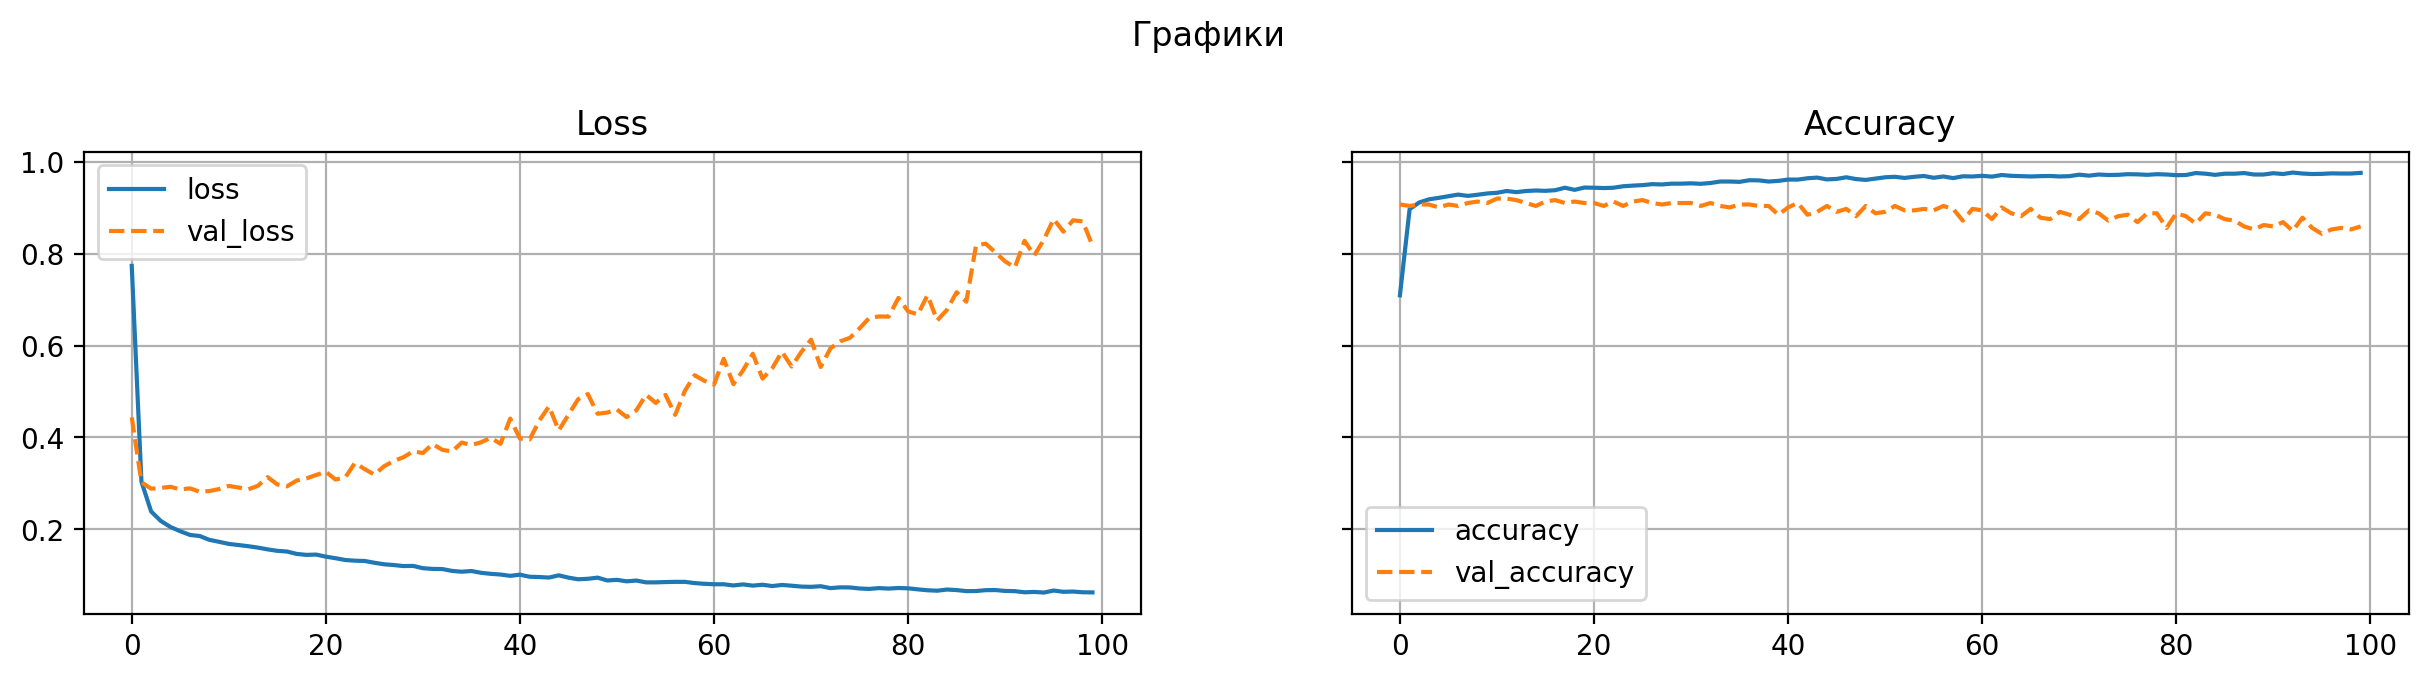

In [ ]:
visualization(history_1)

98/98 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.80      0.84      0.82       309
ограниченно годен       0.80      0.84      0.82       230
         не годен       0.99      0.89      0.94       243

         accuracy                           0.86       782
        macro avg       0.87      0.86      0.86       782
     weighted avg       0.86      0.86      0.86       782



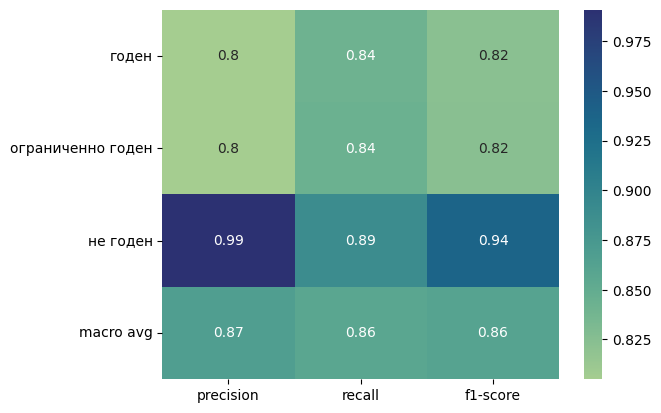

In [ ]:
class_report(model_1)


1.   Виден сильный эффект переобучения сети
2.   Параметр "не годен" не определяется сетью, "ограниченно годен" в очень малом %
> Выводы: необходимо принятие мер по снижению эффекта переобучения и балансировке датасета










---



### 06_2 Эксперимент №2 - 3 Dense слоя + слои нормализации BatchNormalization


> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов


In [ ]:
model_2 = Sequential()
model_2.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_2.add(BatchNormalization())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dense( 3, activation = 'softmax'))

# model_2.summary()

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_2 = model_2.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
176/176 [==============================] - 3s 8ms/step - loss: 0.4672 - accuracy: 0.8141 - val_loss: 0.9628 - val_accuracy: 0.3642
Epoch 2/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2811 - accuracy: 0.8962 - val_loss: 0.5977 - val_accuracy: 0.6933
Epoch 3/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2327 - accuracy: 0.9133 - val_loss: 0.2978 - val_accuracy: 0.8946
Epoch 4/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2082 - accuracy: 0.9211 - val_loss: 0.2778 - val_accuracy: 0.8978
Epoch 5/100
176/176 [==============================] - 1s 6ms/step - loss: 0.2094 - accuracy: 0.9239 - val_loss: 0.2945 - val_accuracy: 0.9073
Epoch 6/100
176/176 [==============================] - 1s 6ms/step - loss: 0.1920 - accuracy: 0.9293 - val_loss: 0.2832 - val_accuracy: 0.9010
Epoch 7/100
176/176 [==============================] - 2s 9ms/step - loss: 0.1846 - accuracy: 0.9296 - val_loss: 0.2730 - val_accuracy: 0.9105

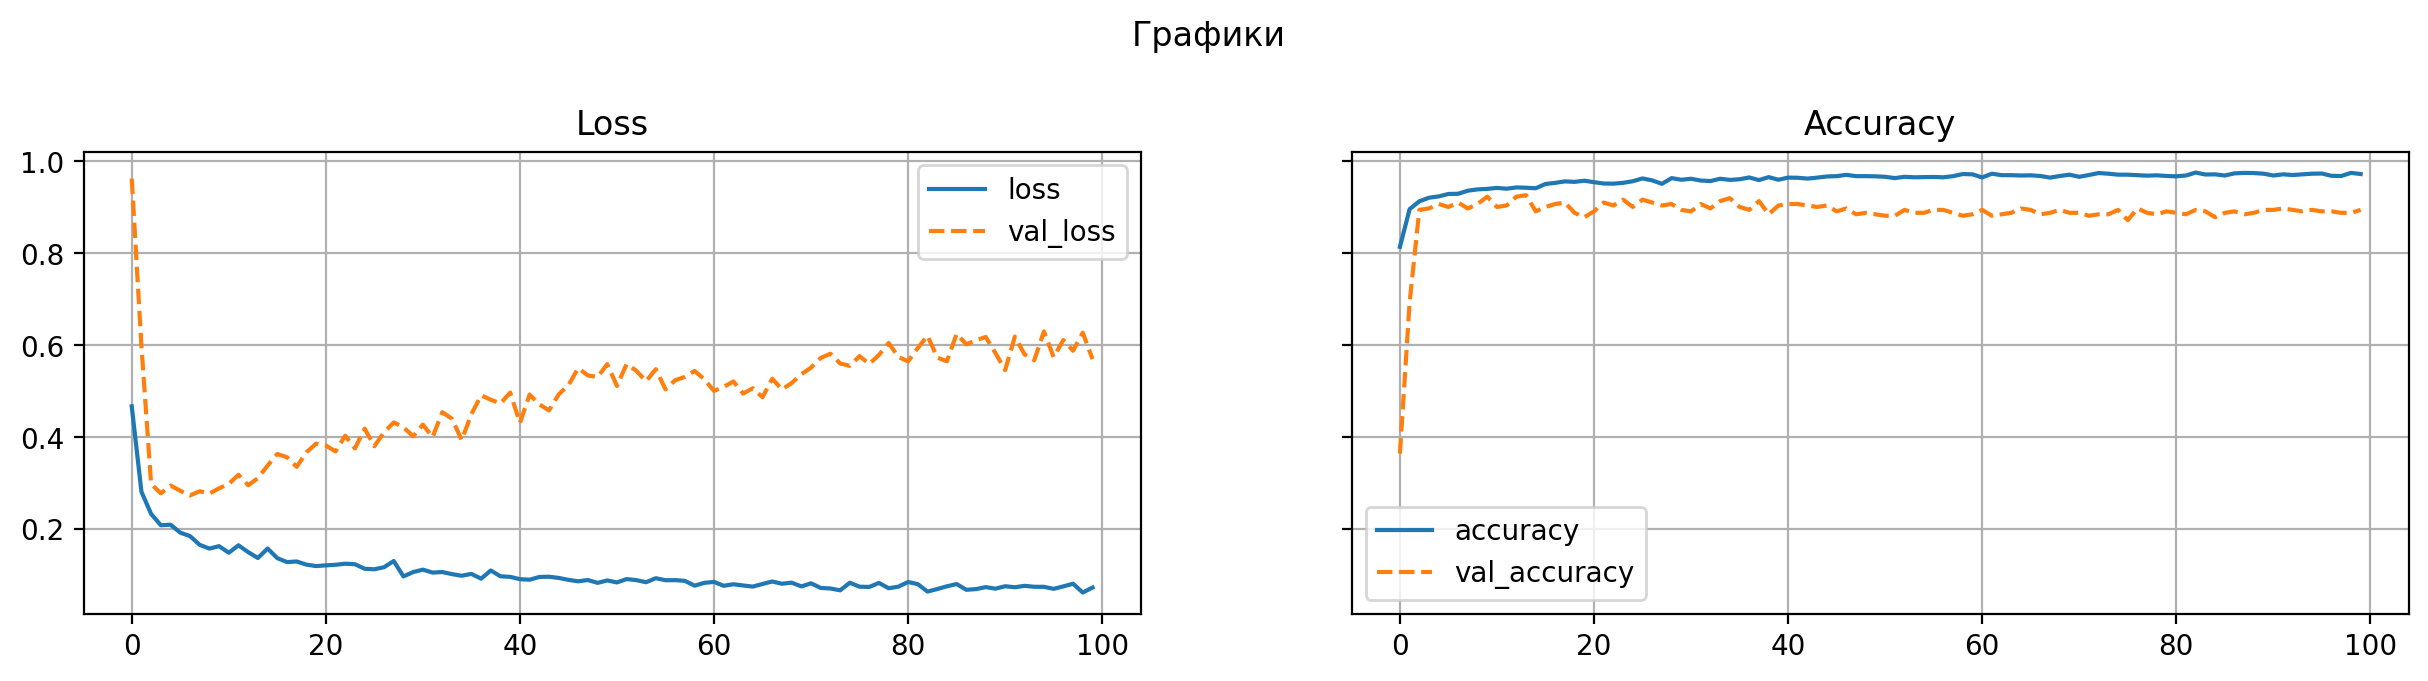

98/98 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.89      0.86      0.88       309
ограниченно годен       0.84      0.89      0.86       230
         не годен       0.99      0.97      0.98       243

         accuracy                           0.91       782
        macro avg       0.91      0.91      0.91       782
     weighted avg       0.91      0.91      0.91       782



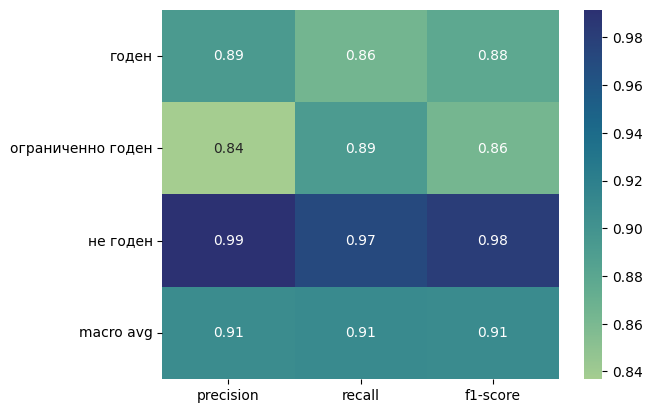

In [ ]:
visualization(history_2)
class_report(model_2)


1.   Как и в предыдущем эксперименте присутствует эффект переобучения сети, тоже достаточно сильно выражен
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" в очень малом %
> Выводы: слоев BatchNormalization недостаточно необходимо принятие мер по снижению эффекта переобучения и балансировке датасета




---



### 06_3 Эксперимент №3 - 3 Dense слоя + слои нормализации Dropout() + BatchNormalization()

> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов

In [ ]:
model_3 = Sequential()

model_3.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(32, activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense( 3, activation = 'softmax'))

# model_3.summary()

model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_3 = model_3.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
176/176 [==============================] - 3s 8ms/step - loss: 0.7483 - accuracy: 0.6801 - val_loss: 0.9648 - val_accuracy: 0.5048
Epoch 2/100
176/176 [==============================] - 1s 7ms/step - loss: 0.4115 - accuracy: 0.8510 - val_loss: 0.5833 - val_accuracy: 0.9010
Epoch 3/100
176/176 [==============================] - 2s 10ms/step - loss: 0.3363 - accuracy: 0.8727 - val_loss: 0.3194 - val_accuracy: 0.9010
Epoch 4/100
176/176 [==============================] - 2s 10ms/step - loss: 0.2910 - accuracy: 0.8912 - val_loss: 0.2496 - val_accuracy: 0.9137
Epoch 5/100
176/176 [==============================] - 2s 9ms/step - loss: 0.2836 - accuracy: 0.8955 - val_loss: 0.2565 - val_accuracy: 0.9201
Epoch 6/100
176/176 [==============================] - 1s 7ms/step - loss: 0.2704 - accuracy: 0.8919 - val_loss: 0.2743 - val_accuracy: 0.9169
Epoch 7/100
176/176 [==============================] - 1s 7ms/step - loss: 0.2650 - accuracy: 0.9065 - val_loss: 0.2939 - val_accuracy: 0.90

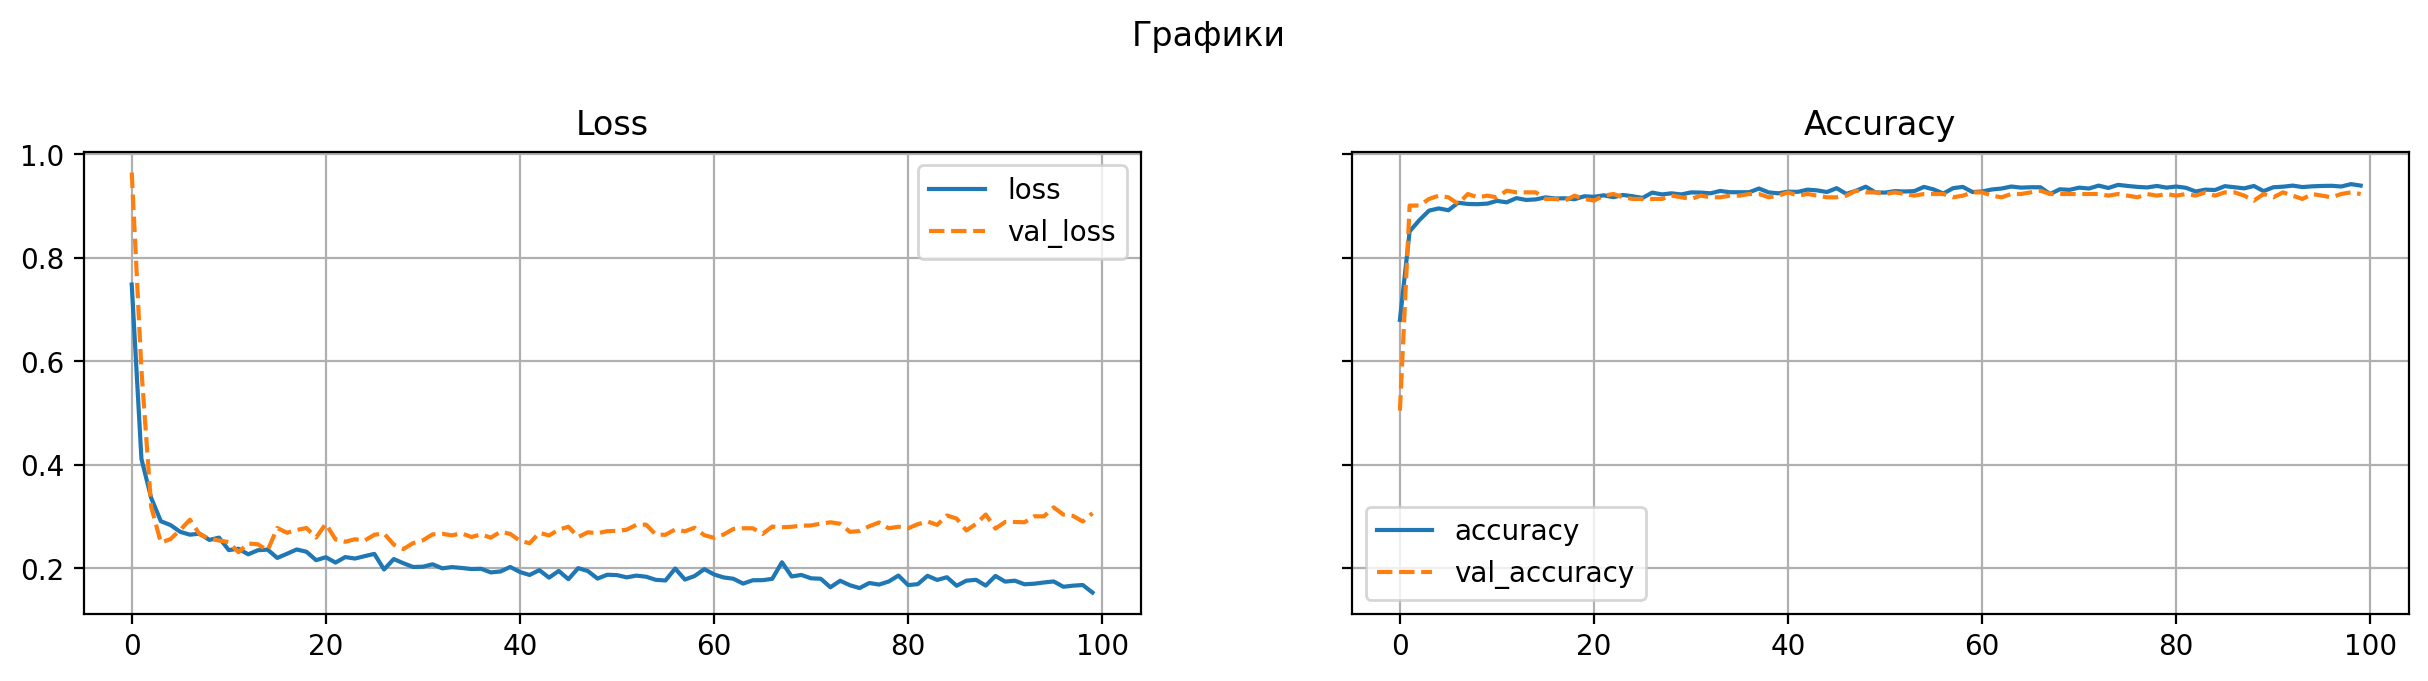

98/98 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.93      0.83      0.88       309
ограниченно годен       0.81      0.95      0.87       230
         не годен       0.99      0.97      0.98       243

         accuracy                           0.91       782
        macro avg       0.91      0.92      0.91       782
     weighted avg       0.91      0.91      0.91       782



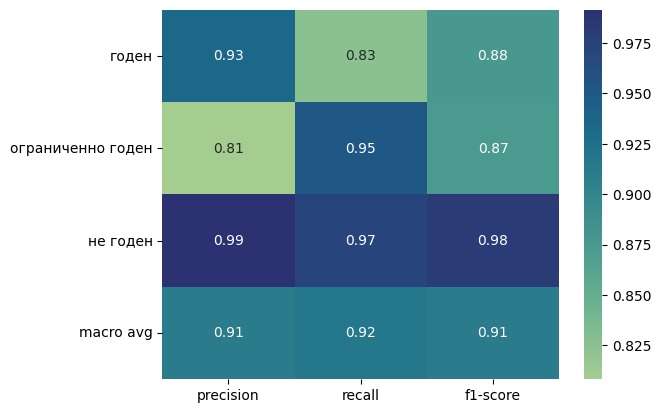

In [ ]:
visualization(history_3)
class_report(model_3)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % обнаружения снизился по сравнению с предыдущими экспериментами
> Выводы: необходимо принятие дополнительных мер по балансировке датасета






---



### 06_4 Эксперимент №4 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization()


In [ ]:
model_4 = Sequential()
model_4.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(32, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(64, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense( 3, activation = 'softmax'))

# model_4.summary()

model_4.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_4 = model_4.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
176/176 [==============================] - 4s 9ms/step - loss: 0.8961 - accuracy: 0.6100 - val_loss: 0.9589 - val_accuracy: 0.4026
Epoch 2/100
176/176 [==============================] - 2s 10ms/step - loss: 0.5305 - accuracy: 0.7814 - val_loss: 0.5084 - val_accuracy: 0.7572
Epoch 3/100
176/176 [==============================] - 2s 11ms/step - loss: 0.4299 - accuracy: 0.8319 - val_loss: 0.3055 - val_accuracy: 0.8946
Epoch 4/100
176/176 [==============================] - 1s 7ms/step - loss: 0.3809 - accuracy: 0.8521 - val_loss: 0.2864 - val_accuracy: 0.9073
Epoch 5/100
176/176 [==============================] - 1s 7ms/step - loss: 0.3553 - accuracy: 0.8603 - val_loss: 0.2682 - val_accuracy: 0.9169
Epoch 6/100
176/176 [==============================] - 1s 7ms/step - loss: 0.3321 - accuracy: 0.8784 - val_loss: 0.2696 - val_accuracy: 0.9137
Epoch 7/100
176/176 [==============================] - 1s 7ms/step - loss: 0.2839 - accuracy: 0.8912 - val_loss: 0.2626 - val_accuracy: 0.90

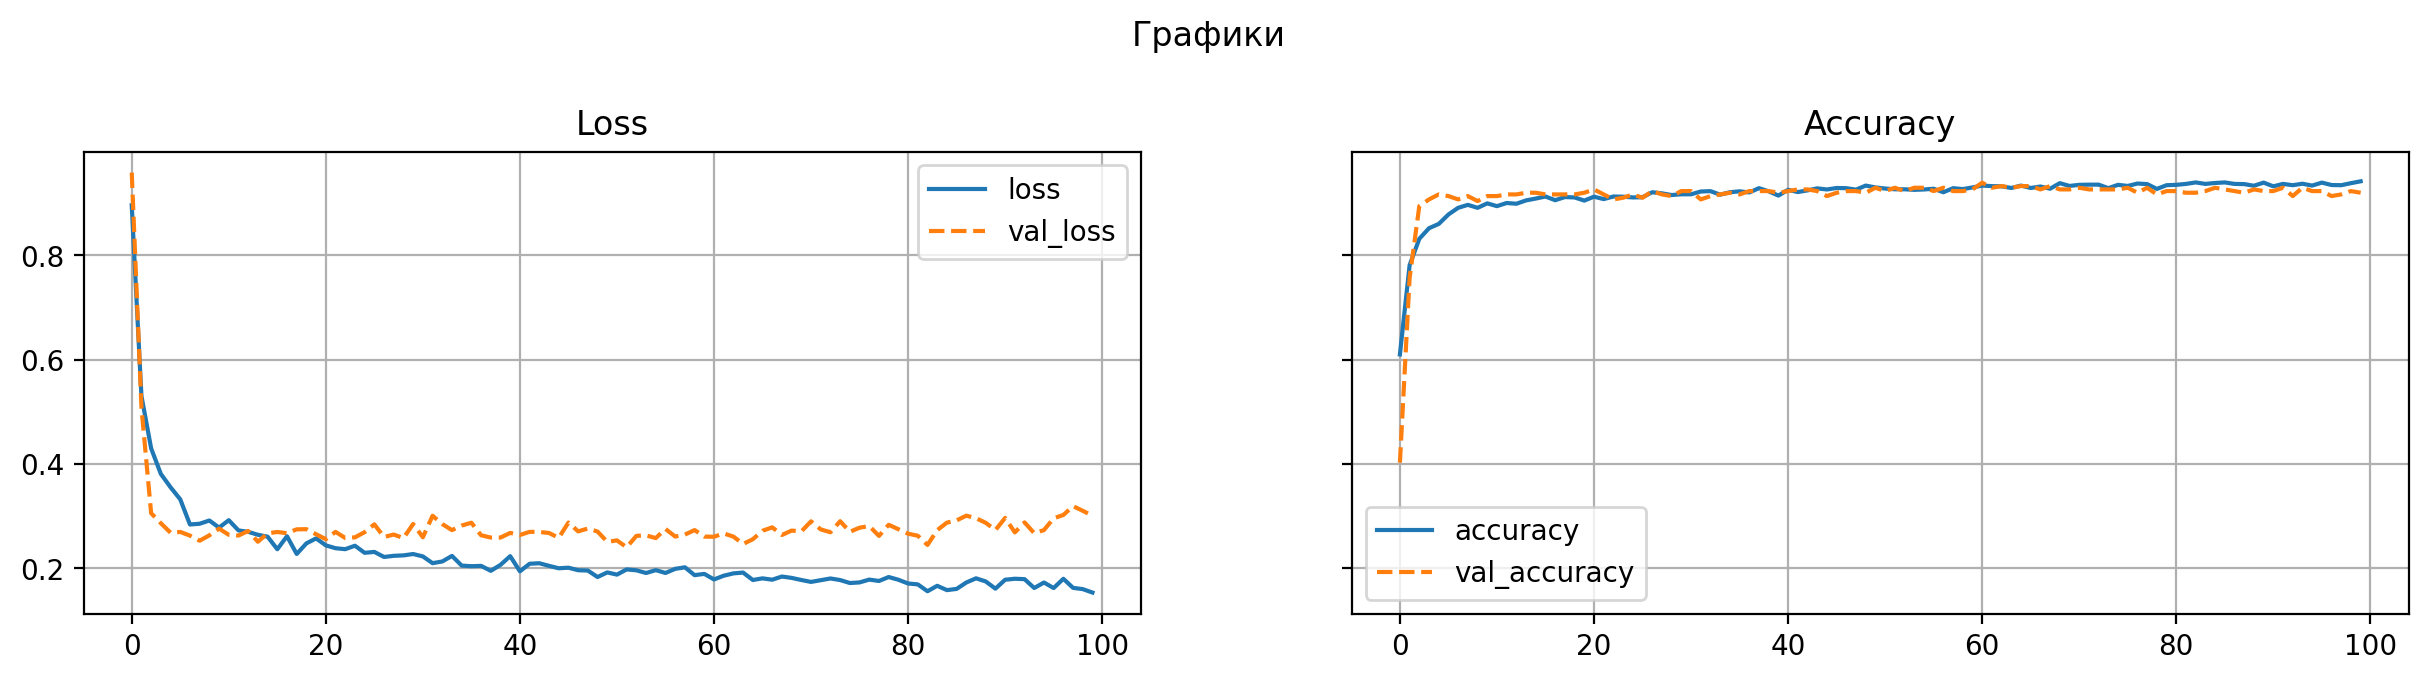

98/98 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.82      0.88       309
ограниченно годен       0.81      0.96      0.88       230
         не годен       0.99      0.97      0.98       243

         accuracy                           0.91       782
        macro avg       0.91      0.92      0.91       782
     weighted avg       0.92      0.91      0.91       782



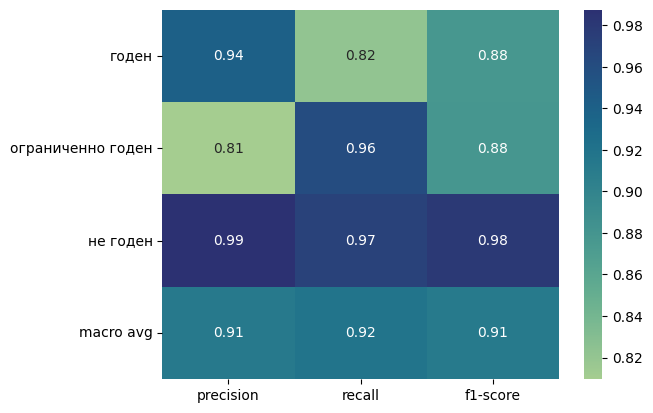

In [ ]:
visualization(history_4)
class_report(model_4)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % обнаружения повысился по сравнению с предыдущими экспериментами
> Выводы: также необходимо принятие дополнительных мер по балансировке датасета + данную архитектуру можно взять за основу для дальнейших экспериментов





---



### 06_5 Эксперимент №5 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization() + увеличение количества эпох и callback для изменения learning rate

In [ ]:
# определяем callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.00001,
                              cooldown=0,
                              min_lr=1e-10
)

In [ ]:
model_5 = Sequential()
model_5.add(Dense(32, activation = 'sigmoid', input_shape=(x_train_dataset.shape[1],)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(64, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(128, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(256, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(512, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense( 3, activation = 'softmax'))

# model_5.summary()

model_5.compile(optimizer=Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_5 = model_5.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=64,
                        epochs=500,
                        validation_split=0.2) #,
                        # callbacks=[reduce_lr])

Epoch 1/500
40/40 [==============================] - 6s 31ms/step - loss: 1.9715 - accuracy: 0.3364 - val_loss: 1.2578 - val_accuracy: 0.2812
Epoch 2/500
40/40 [==============================] - 1s 23ms/step - loss: 1.8038 - accuracy: 0.3752 - val_loss: 1.2102 - val_accuracy: 0.2812
Epoch 3/500
40/40 [==============================] - 1s 22ms/step - loss: 1.8281 - accuracy: 0.3536 - val_loss: 1.1775 - val_accuracy: 0.2812
Epoch 4/500
40/40 [==============================] - 1s 22ms/step - loss: 1.7324 - accuracy: 0.3916 - val_loss: 1.1555 - val_accuracy: 0.2812
Epoch 5/500
40/40 [==============================] - 1s 22ms/step - loss: 1.7245 - accuracy: 0.3996 - val_loss: 1.1388 - val_accuracy: 0.2812
Epoch 6/500
40/40 [==============================] - 1s 22ms/step - loss: 1.6122 - accuracy: 0.4064 - val_loss: 1.1264 - val_accuracy: 0.2812
Epoch 7/500
40/40 [==============================] - 1s 22ms/step - loss: 1.6398 - accuracy: 0.4108 - val_loss: 1.1171 - val_accuracy: 0.2812
Epoch 

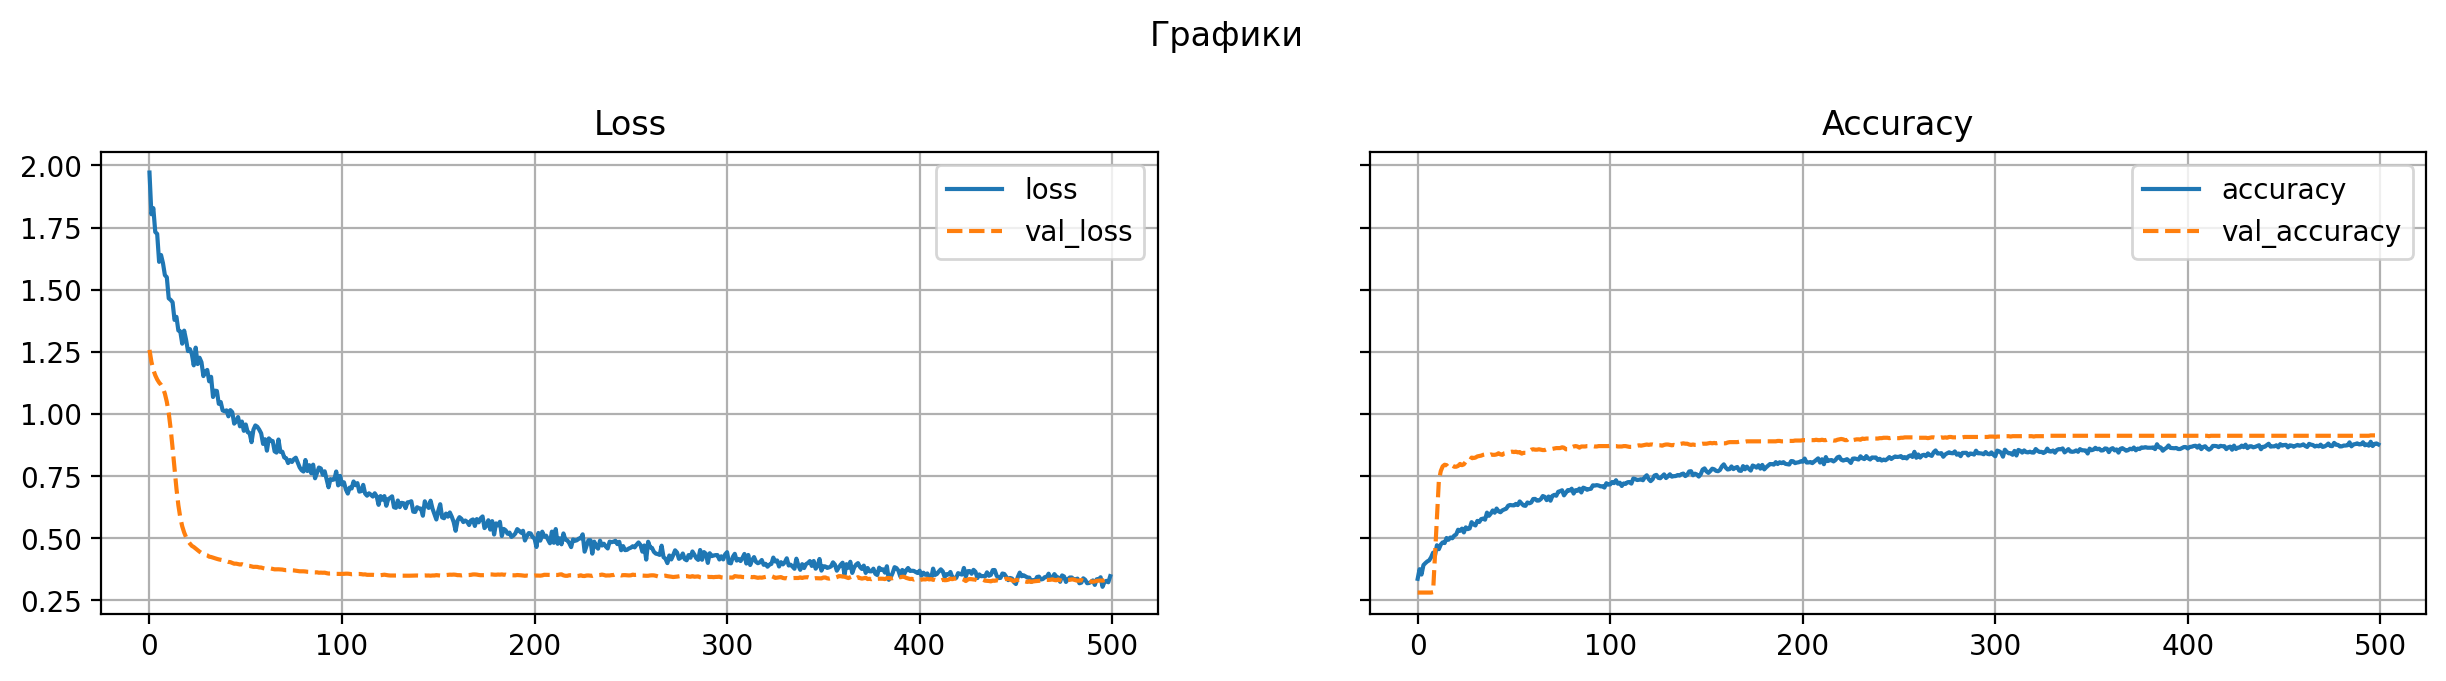

98/98 [==============================] - 0s 3ms/step
                   precision    recall  f1-score   support

            годен       0.94      0.83      0.88       309
ограниченно годен       0.81      0.96      0.88       230
         не годен       0.99      0.97      0.98       243

         accuracy                           0.91       782
        macro avg       0.91      0.92      0.91       782
     weighted avg       0.92      0.91      0.91       782



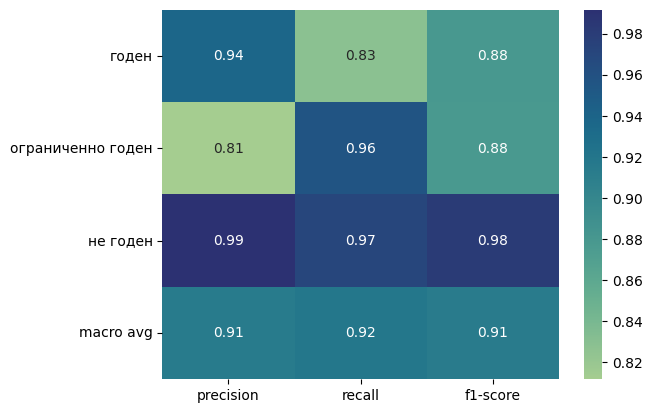

In [ ]:
visualization(history_5)
class_report(model_5)

1.   Эффекта переобучения практически не наблюдается
2.   Результаты отличаются незначительно от предыдущих экспериментов, несмотря на значительное увеличение количества эпох и снижении learning rate
2.   Параметр "не годен" также не определяется сетью, "ограниченно годен" % тоже не обнружен

> Выводы: Настоящий датасет не позволяет добиться поставленной цели, также на предоставленных данных довольно сложно оценить дальнейшее направление работ.



# Общие выводы по проекту

Разбалансированный датасет не позволяет эффективно и корректно настроить нейросеть.

Рекомендации по подготовке датасета:

1. Сложно было работать с дтасетом, где очень много задвоенных данных. Причем данные, которые по логике, должны быть одинаковы могут отличаться. Учитывая данный момент


> Рекомендация 1: совместно с профпатологом, либо на основании к-л методических рекомендаций составить схему данных, которые влияют на принятие решений и сформировать выгрузку только релевантных значений, это значительно сократит время обработки датасета.


2. Данные не сбалансированы. Слишком мало данных для обучения нейросети и по результатам видно, что нейросеть достаточно успешно выделят признак "годен", но насколько она это делает следуя алгоритму (а не просто угадывая) на текущих данных не определить.


> Рекомендация 2: провести балансировку датасета. Возможно следует искуственно расширить данные (для несуществующих пациентов), но расширение датасета следует проводить с консультациями экспертов (врача профпатолога или профильных специалистов)

3. Скорректировать представление в датасете категориальных данных - часто наблюдалось, что категориальные данные либо разделены на несколько колонок, либо вводятся не из справочника, либо друг друга дублируют, либо друг другу противоречат.
Например я бы добавила ряд категориальных данных из заключений профильных специалистов, для проверки гипотезы по их влиянию на результат, но при такой разбалансировке очень сложно будет оценить их влияние.




# Вывод предсказаний сети ( в разработке)

> Indented block

